# Assignment 4 - Exercise 1

Daskalopoulos Ioannis (f3351805)<br>
Ntouskas Fotios (f3351813)<br>
Palassopoulos Vasileios (f3351814)<br>
Spantouri Natalia (f3351817)<br>

## Importing Libraries & Embeddings

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import os
import glob
import numpy as np
import pandas as pd
import pickle
import copy
import itertools
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, vstack

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit, learning_curve
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, auc, precision_recall_curve
from sklearn.dummy import DummyClassifier
import sklearn.exceptions
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.layers import InputSpec
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras_tqdm import TQDMNotebookCallback
from keras.models import Model
from keras.layers import Dense, Dropout, Bidirectional, Input
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Adam
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
'''
To load fasttext pre-trained embeddings more efficiently,
we can read only once the embeddings file and save:
1/ A 2D np-array for the embedding vectors 
2/ A dictionary that maps each word to the row index of its
    embedding on the 2D np-array
'''

idx = 0
vocab = {}
with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        if idx == 0:
            vocab_size = int(line[0]) + 1
            dim = int(line[1])
            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
            vocab["__PADDING__"] = 0
            idx = 1
        else:
            vocab[line[0]] = idx
            emb = np.array(line[1:]).astype(np.float)
            if (emb.shape[0] == dim):
                vecs[idx,:] = emb
                idx+=1
            else:
                continue

    pickle.dump(vocab,open("fasttext_voc",'wb'))
    np.save("fasttext.npy",vecs)

In [3]:
# Load embeddings np-array and mapping dictionary
fasttext_embed = np.load("fasttext.npy")
fasttext_word_to_index = pickle.load(open("fasttext_voc", 'rb'))

## Reading Emails Recursively by Class

In [4]:
#Get root folder, Extensions that will be read, Class Label
def read_data(directory,file_extension,class_label):
    
    data = []
    index = []
    #Recursively read file paths starting from root directory, ending with the specisfied extension, 2 levels deep
    for filename in glob.glob(directory+'/**/*'+file_extension, recursive=True):
        email_content = ""                                                   #This is our email string
        with open(filename, 'r',encoding='utf-8', errors='ignore') as email: #Open the file in the located file path
            for line in email:                        #Read the email line by line and replace the tabs and new lines with space
                line = line.replace('\n', ' ')
                line = line.replace('\t', ' ')
                email_content+= line                               #Append the line to the email string
        email.close()                                              #Close the file
        data.append({'text': email_content, 'label': class_label}) #Append a dictionary with email string and class label
        index.append(filename)                                     #Append the path
                    
    return data,index

In [5]:
Enron_dataset_dir = os.getcwd() + "\\Enron_dataset" #Path
Ham_data,index_hamdata = read_data(Enron_dataset_dir,".ham.txt","Ham")           #Create array with Ham emails
Spam_data,index_spamdata = read_data(Enron_dataset_dir,".spam.txt","Spam")       #Create array with Spam emails
data = pd.DataFrame(Ham_data,index =index_hamdata)                               #Make them a dataframe with their path as the index
data = data.append(pd.DataFrame(Spam_data,index =index_spamdata))                #Append the spam data
#shuffle dataframe      
data = shuffle(data,random_state = 456987)                                       
pd.set_option("max_colwidth",2000)                                               #Set max columns to not overload Jupyter
data.head(3)

,label,text
C:\Users\Fotis\Desktop\Enron_dataset\Enron_dataset\enron4\spam\1306.2004-05-29.GP.spam.txt,Spam,Subject: re : are you still online ? click here to be removed
C:\Users\Fotis\Desktop\Enron_dataset\Enron_dataset\enron4\spam\0347.2004-02-05.GP.spam.txt,Spam,"Subject: hi if you are paying more than 3 . 6 % on your mortgage , we can save you money ! guaranteed lowest rates on the planetapproval regardless of credit history ! start saving todayshow me the lowest rates to stop receiving offers here"
C:\Users\Fotis\Desktop\Enron_dataset\Enron_dataset\enron6\spam\2646.2005-01-11.BG.spam.txt,Spam,"Subject: urgent hi , i hereby wish to inform you that i am interested to purchase your , pci cardteac cd - w 54 e cd - r / rw burner , sony sdt - 5000 dds 2 ( 4 / 8 gb ) dat drive , sony 15 cl dds dat cleaning tape . what is your best offer ? are you the real owner ? what is the condition ? payment will be by money order . dont worried yourself about the pick up . i will take care of that when payment is done . if its still available for sale , provide the details below with which the payment will be sent to . . . offeri look forward to read from you soonest . cheers _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ do you yahoo ! ? tired of spam ? yahoo ! mail has the best spam protection around http : / / mail . yahoo . com"


In [6]:
data.shape
data['label'].value_counts()

Spam    17171
Ham     16545
Name: label, dtype: int64

## Splitting into Test, Held-out and Train sets

In [7]:
train, heldout, test  = np.split(data, [int(.6*len(data)), int(.8*len(data))])

In [8]:
x_train = list(itertools.chain.from_iterable(train[['text']].values.tolist())) #Extract x_train from the train set
x_heldout = list(itertools.chain.from_iterable(heldout[['text']].values.tolist())) #Extract x_heldout from the heldout set
x_test = list(itertools.chain.from_iterable(test[['text']].values.tolist()))   #Extract x_test from the test set

In [9]:
y_train = list(itertools.chain.from_iterable(train[['label']].values.tolist())) #Extract training labels
le = preprocessing.LabelEncoder()                                               #Initialize Labelencoder
le.fit(y_train)                                                                 
y_train = le.transform(y_train)                                                 #Y_train classes become 0 and 1
y_heldout = le.transform(list(itertools.chain.from_iterable(heldout[['label']].values.tolist())))
y_test = le.transform(list(itertools.chain.from_iterable(test[['label']].values.tolist()))) #Same for y_test

## Creating functions for recall, precision, f1 and accuracy scores

In [10]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

## Convert texts to sequence of indexes and padding

In [11]:
MAX_WORDS =20000
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train)
train_seqs = tokenizer.texts_to_sequences(x_train)
heldout_seqs = tokenizer.texts_to_sequences(x_heldout)
test_seqs = tokenizer.texts_to_sequences(x_test)
train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH)
heldout_data = pad_sequences(heldout_seqs, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH)

In [12]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 124106 unique tokens.


## Define model's embedding matrix

In [13]:
embedding_matrix = np.zeros((MAX_WORDS+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

## Custom keras layer for linear attention over RNNs output states

In [14]:
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average attention mechanism 
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.w = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_w'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.w]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, h, mask=None):
        h_shape = K.shape(h)
        d_w, T = h_shape[0], h_shape[1]
        
        logits = K.dot(h, self.w)  # w^T h
        logits = K.reshape(logits, (d_w, T))
        alpha = K.exp(logits - K.max(logits, axis=-1, keepdims=True))  # exp
        
        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            alpha = alpha * mask
        alpha = alpha / K.sum(alpha, axis=1, keepdims=True) # softmax
        r = K.sum(h * K.expand_dims(alpha), axis=1)  # r = h*alpha^T
        h_star = K.tanh(r)  # h^* = tanh(r)
        if self.return_attention:
            return [h_star, alpha]
        return h_star

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

## RandomizedSearchCV RNN + linear attention model with an MLP on top of it

In [15]:
def create_model(input_layer_units=512, hidden_layers=1, dropout=0.5, optimizer='adam', SIZE = 100, method=GRU, number_RNNs=1):
    
    inputs = Input((MAX_SEQUENCE_LENGTH,))
    embeddings = Embedding(MAX_WORDS+1,EMBEDDING_DIM, weights=[embedding_matrix],
                           input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
    drop_emb = Dropout(dropout)(embeddings)
    
    for k in range(number_RNNs):
        if k == 0:
            bilstm = Bidirectional(method(units=SIZE, return_sequences=True))(drop_emb)
        else:
            bilstm = Bidirectional(method(units=SIZE, return_sequences=True))(bilstm)
            
    x, attn = AttentionWeightedAverage(return_attention=True)(bilstm)
    
    for i in range(hidden_layers):
        if i == 0:
            out = Dense(units=input_layer_units, activation="relu")(x)
        else:
            input_layer_units = input_layer_units//2
            out = Dense(units=input_layer_units, activation="relu")(out)
        out = Dropout(dropout)(out)
    
    out = Dense(units=1, activation="sigmoid")(out)
    model = Model(inputs, out)

    print(model.summary())
    model.compile(loss='binary_crossentropy',
                      optimizer=Adam(lr=0.001),
                      metrics=[f1])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
hyperparameters = {
    'method': [LSTM,GRU],
    'SIZE': [100,200,300],
    'number_RNNs':  np.arange(1,5,1),
    'input_layer_units': [256, 512],
    'hidden_layers' : np.arange(1,3,1),
    'batch_size' : [32, 64],
    'dropout' : np.linspace(0,0.5,5),
    'epochs': np.arange(0,15,2)
}

rnd_search = RandomizedSearchCV(model, hyperparameters, n_iter = 10, scoring='f1', cv=2, verbose=0, n_jobs=1)
best_model = rnd_search.fit(heldout_data,y_heldout)
# summarize results
print("Best: %f using %s" % (best_model.best_score_, best_model.best_params_))
means = best_model.cv_results_['mean_test_score']
stds = best_model.cv_results_['std_test_score']
params = best_model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.972871 using {'number_RNNs': 1, 'method': <class 'keras.layers.recurrent.GRU'>, 'input_layer_units': 512, 'hidden_layers': 1, 'epochs': 8, 'dropout': 0.0, 'batch_size': 64, 'SIZE': 200}
0.941035 (0.002137) with: {'number_RNNs': 2, 'method': <class 'keras.layers.recurrent.GRU'>, 'input_layer_units': 256, 'hidden_layers': 1, 'epochs': 2, 'dropout': 0.0, 'batch_size': 32, 'SIZE': 300}
0.968523 (0.006974) with: {'number_RNNs': 4, 'method': <class 'keras.layers.recurrent.LSTM'>, 'input_layer_units': 512, 'hidden_layers': 1, 'epochs': 14, 'dropout': 0.0, 'batch_size': 32, 'SIZE': 100}
0.972871 (0.000388) with: {'number_RNNs': 1, 'method': <class 'keras.layers.recurrent.GRU'>, 'input_layer_units': 512, 'hidden_layers': 1, 'epochs': 8, 'dropout': 0.0, 'batch_size': 64, 'SIZE': 200}
0.963189 (0.000548) with: {'number_RNNs': 1, 'method': <class 'keras.layers.recurrent.LSTM'>, 'input_layer_units': 512, 'hidden_layers': 1, 'epochs': 4, 'dropout': 0.0, 'batch_size': 32, 'SIZE': 300}
0.96806

## Appending the heldout set on the train set

In [16]:
train_data=vstack((train_data, heldout_data)).tocsr()
y_train=np.concatenate([y_train, y_heldout],axis=0)

## Create and train a Bi-LSTM + linear attention model with an MLP on top of it using optimal parameters

In [17]:
GRU_SIZE = 200
DENSE = 512
N_CLASSES = 1

def create_model(optimizer='adam'):
    inputs = Input((MAX_SEQUENCE_LENGTH,))
    embeddings = Embedding(MAX_WORDS+1,EMBEDDING_DIM, weights=[embedding_matrix], 
                        input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
    drop_emb = Dropout(0)(embeddings)
    bilstm = Bidirectional(GRU(units=GRU_SIZE, return_sequences=True))(drop_emb)
    x, attn = AttentionWeightedAverage(return_attention=True)(bilstm)
    out = Dense(units=DENSE, activation="relu")(x)
    out = Dense(units=N_CLASSES, activation="sigmoid")(out)
    model = Model(inputs, out)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])
    return model

model = KerasClassifier(build_fn=create_model, epochs=8, batch_size=64, verbose=0)

checkpoint = ModelCheckpoint('keras_BiLSTM+attn_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

train_performance=model.fit(train_data, y_train,
              batch_size=64,
              epochs=8,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback()],
              validation_data=(test_data, y_test))


Epoch 00001: val_f1 improved from -inf to 0.96660, saving model to keras_BiLSTM+attn_model



Epoch 00002: val_f1 improved from 0.96660 to 0.97487, saving model to keras_BiLSTM+attn_model



Epoch 00003: val_f1 improved from 0.97487 to 0.97850, saving model to keras_BiLSTM+attn_model



Epoch 00004: val_f1 improved from 0.97850 to 0.98097, saving model to keras_BiLSTM+attn_model



Epoch 00005: val_f1 improved from 0.98097 to 0.98366, saving model to keras_BiLSTM+attn_model



Epoch 00006: val_f1 did not improve from 0.98366



Epoch 00007: val_f1 improved from 0.98366 to 0.98658, saving model to keras_BiLSTM+attn_model



Epoch 00008: val_f1 improved from 0.98658 to 0.98745, saving model to keras_BiLSTM+attn_model


## Model Evaluation

In [18]:
GRU_SIZE = 200
DENSE = 512
N_CLASSES = 1

inputs = Input((MAX_SEQUENCE_LENGTH,))
embeddings = Embedding(MAX_WORDS+1,EMBEDDING_DIM, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
drop_emb = Dropout(0)(embeddings)
bilstm = Bidirectional(GRU(units=GRU_SIZE, return_sequences=True))(drop_emb)
x, attn = AttentionWeightedAverage(return_attention=True)(bilstm)
out = Dense(units=DENSE, activation="relu")(x)
out = Dense(units=N_CLASSES, activation="sigmoid")(out)
modelev = Model(inputs, out)

print(modelev.summary())

modelev.load_weights("keras_BiLSTM+attn_model")
modelev.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1, accuracy])

score = modelev.evaluate(
    test_data,
    y_test,          
    batch_size=64,
    verbose=1)

print('\nTest Binary_cross_entropy: %.4f' %  (score[0]))
print('\nTest precision: %.4f' %  (score[1]))
print('\nTest recall: %.4f' %  (score[2]))
print('\nTest f1: %.4f' % (score[3]))
print('\nTest accuracy: %.4f'% (score[4]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 1000, 300)         6000300   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000, 300)         0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 1000, 400)         601200    
_________________________________________________________________
attention_weighted_average_1 [(None, 400), (None, 1000 400       
_________________________________________________________________
dense_25 (Dense)             (None, 512)               205312    
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 513       
Total para

## Learning Curves - Precision-Recall Curves

#### Baseline Classifier

In [19]:
clf=DummyClassifier(strategy='most_frequent')
predictions = clf.fit(train_data, y_train).predict(test_data)
print("train f1-score:",f1_score(y_test,predictions))

predictions_test = clf.predict(test_data)
print("test f1-score:",f1_score(y_test, predictions_test))
print()
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
display(pd.crosstab(y_true, y_pred))

train f1-score: 0.6779062928837484
test f1-score: 0.6779062928837484

test data confusion matrix


Predicted,1
True,
0,3286
1,3458


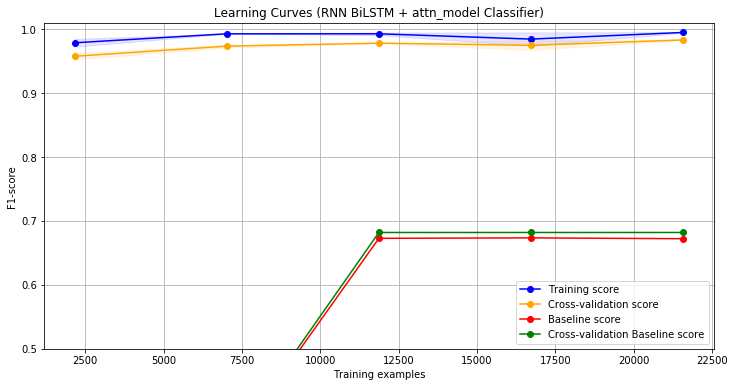

In [20]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure(figsize=(12, 6))
    plt.title('Learning Curves (%s)' % (title))
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring='f1', train_sizes=train_sizes, verbose=0)
    
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")
    
    train_sizes, train_scores, test_scores = learning_curve(
    DummyClassifier(strategy='most_frequent'), X, y, cv=cv, n_jobs=n_jobs, scoring='f1', train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Baseline score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", 
             label="Cross-validation Baseline score")

    plt.legend(loc="lower right")
    return plt

cv = ShuffleSplit(n_splits=2, test_size=0.2)
plot_learning_curve(model, 'RNN BiLSTM + attn_model Classifier', train_data, y_train, ylim=(0.5, 1.01), cv=cv, n_jobs=1)
plt.show()

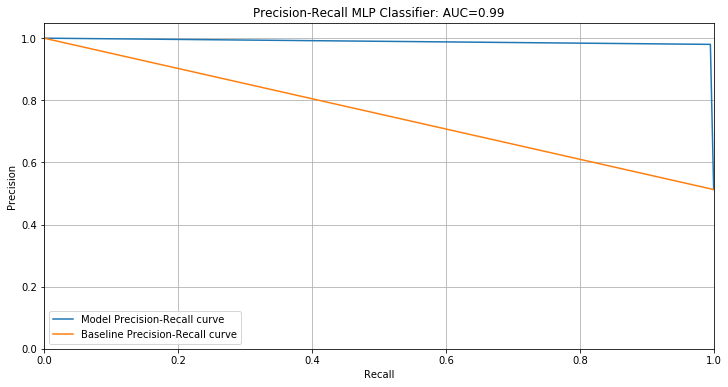

In [21]:
np.seterr(all='ignore')
    
pred = model.predict(test_data)
precision, recall, thresholds = precision_recall_curve(y_test, pred)
area = auc(recall, precision)

plt.figure(figsize=(12, 6))
plt.plot(recall, precision, label='Model Precision-Recall curve')

pred = DummyClassifier(strategy='most_frequent').fit(train_data,y_train).predict(test_data)
precision, recall, thresholds = precision_recall_curve(y_test, pred)

plt.plot(recall, precision, label='Baseline Precision-Recall curve')
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' % ('MLP Classifier',area))
plt.legend(loc="lower left")
plt.show()

## Checking the misclassified results

In [22]:
def get_email_from_dataset(index_pos):
    print('True Email Class: ' + test.iloc[index_pos]['label'])
    print(test.iloc[index_pos]['text'][:2000] + '....')
    print()

In [23]:
predict_array = modelev.predict(test_data).reshape((-1,))
########### Aftes oi grammes allaksane ##############
predict_classes_array = copy.deepcopy(predict_array)
predict_classes_array[predict_classes_array<0.5] = 0
predict_classes_array[predict_classes_array>=0.5] = 1
####################################################
real_classes_array = y_test
predict_array[predict_classes_array == 0] = 1 - predict_array[predict_classes_array == 0]
predict_array[predict_classes_array == real_classes_array] = 0
misclassifications = np.argsort(predict_array)[::-1]

for index, _ in zip(misclassifications, range(20)):
    get_email_from_dataset(index)

True Email Class: Spam
Subject: best regards dear friend , good day to you . i may have to trouble your sense of personal achievement and reward for an opportunity properly taken advantage of . i am mr . michael ramsey , a representative and an attorney to kenneth lay , the former chairman & ceo , enron corp . industry : energy & natural resources home , is presently in jail and facing trial on charges of corruption and embezzlement of funds while in power . he deposited twenty one million u . s dollars ( $ 21 , 000 , 000 . 00 ) with me when he was in power as the chairman . i am contacting you because i want you to deal with the finance house and claim the money on my behalf since i have declared that the funds belong to my foreign business partner . you shall also be required to assist me in investment in your country . i hope to trust you as a god fearing person who will not sit on this money when you claim it , rather assist me properly , shared in these percentages , 60 % to me an

Subject:  press here to enter a license . supporters of the amended version might argue that the references to crew and . in how the law is enforced . for his part , case acknowledged that the changes might seem reasonable " but if you understand the issues and youlook at what they really mean , i think a reasonable person would agree that ' fly at your risk ' insinuatory 9 ....

True Email Class: Ham
Subject: performance reviews completed and turned in 10 / 12 / 00 hector and shanna , my three outstanding reviews have been turned into hr this afternoon . no other reviews are outstanding for my group . thanks . sheila....

True Email Class: Ham
Subject: president @ juno . com : exciting news - free internet access ! - - - - - - - - - begin forwarded message - - - - - - - - - - from : president @ juno . com to : subject : exciting news - free internet access ! date : wed dec 22 16 : 30 : 24 est 1999 message - id : dear juno member , we have exciting news for you ! we have decided to exp